<a href="https://colab.research.google.com/github/KoderDhruv/Learning_ML/blob/main/Disaster_prediction_in_tweets_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jan 26 07:24:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-01-26 07:24:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-26 07:24:45 (101 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"
unzip_data("nlp_getting_started.zip")

--2023-01-26 07:24:49--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.28MB/s    in 0.5s    

2023-01-26 07:24:50 (1.28 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
import pandas as pd
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df_shuffled=train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
import random
random_index=random.randint(0, len(train_df)-6)
for row in train_df_shuffled[['text','target']][random_index:random_index+5].itertuples():
  _, text, target=row
  print(f'Target:{target}')
  print(f'{text}\n')
  print(f'----')  

Target:1
The Cafe Run by Acid Attack Survivors in #India http://t.co/qmiF0bLwOa http://t.co/l6PIf3LpEn

----
Target:0
@Chrisman528 fatality ...

----
Target:0
New on Ebay UK Star Wars Storm Trooper Pop! Vinyl Bobble Head Figure POP Funko http://t.co/KJbXIeypma http://t.co/ENPjCfMa8L

----
Target:0
http://t.co/MoA0q0AuFa Jacksonville family bands together as memorial is planned for toddler who ... - FloridaÛ_ http://t.co/NKOu7zWwRT

----
Target:0
Hibernating pbx irrespective of pitch fatality careerism pan: crbZFZ

----


In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=None,# how many words in vocabulary
                                  standardize='lower_and_strip_punctuation',
                                  split='whitespace',
                                  ngrams=None,# group of n words
                                  output_mode='int',
                                  output_sequence_length=None# length of sequence
                                  )

In [ ]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
max_vocab_length=10000
max_length=15

text_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode='int',
                                  output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
sample_sentence='There is a flood in my street!'
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
random_sentence=random.choice(train_sentences)
print(f'Original Text: {random_sentence}\nVectorized version: {text_vectorizer([sample_sentence])}')

Original Text: Police kill hatchet-wielding gunman who opened fire inside Nashville movie theater: AåÊmiddle-aged manåÊarmed wi... http://t.co/tyD47NfL5x
Vectorized version: [[ 74   9   3 232   4  13 698   0   0   0   0   0   0   0   0]]


In [ ]:
words_in_vocab=text_vectorizer.get_vocabulary() #get all unique words in order of their frequency
print(f'Most occured words are : {words_in_vocab[:10]}')
print(f'Least occured words are : {words_in_vocab[-10:]}')

Most occured words are : ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is']
Least occured words are : ['painthey', 'painful', 'paine', 'paging', 'pageshi', 'pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

embedding=layers.Embedding(input_dim=max_vocab_length,
                           output_dim=128 ,
                           input_length=max_length)
embedding

In [ ]:
random_sentence=random.choice(train_sentences)
print(f'Original text:\n{random_sentence}\n\nEmbedded Version:')
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@a__cee DAEM GIRL SMOOTH ASF c: ?

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.04112394,  0.03503137,  0.04707131, ..., -0.00264418,
          0.03667655,  0.00236906],
        [-0.04112394,  0.03503137,  0.04707131, ..., -0.00264418,
          0.03667655,  0.00236906],
        [-0.02326877,  0.03825779, -0.00614228, ...,  0.01575196,
         -0.03231914, -0.00494938],
        ...,
        [-0.00052379,  0.02979903,  0.02994244, ..., -0.03034287,
         -0.04332073, -0.0072601 ],
        [-0.00052379,  0.02979903,  0.02994244, ..., -0.03034287,
         -0.04332073, -0.0072601 ],
        [-0.00052379,  0.02979903,  0.02994244, ..., -0.03034287,
         -0.04332073, -0.0072601 ]]], dtype=float32)>

In [ ]:
# embedding for single layer is:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-0.04112394,  0.03503137,  0.04707131, -0.00860137, -0.00229521,
        0.00892472,  0.02280122, -0.01919389,  0.00474838,  0.04968261,
       -0.03850802, -0.00835516,  0.02361516, -0.01987405, -0.02579871,
       -0.03506957, -0.02055212,  0.03658017,  0.01226611, -0.00578886,
        0.00274069, -0.00677565, -0.04683096,  0.03928104,  0.04814769,
       -0.00872358,  0.00993713,  0.00332307,  0.01571777, -0.03974662,
       -0.0048756 ,  0.03094003,  0.00770874, -0.0178673 , -0.01604645,
        0.03212315,  0.04159662,  0.04151635,  0.02900106, -0.00495885,
        0.04420625,  0.04440088, -0.03006648, -0.04366877, -0.03098175,
        0.0007364 ,  0.04264499, -0.00102117, -0.00574519,  0.01878781,
        0.03670457, -0.00116064,  0.02785834,  0.04788716,  0.03404892,
       -0.02026742,  0.03637758,  0.04057287,  0.03579428, -0.04631089,
       -0.03701312,  0.04320345,  0.02148578, -0.04250193,  0.04825426,
        0.045676

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0=Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(val_sentences, val_labels)
baseline_score

0.7926509186351706

In [ ]:
baseline_preds=model_0.predict(val_sentences)
baseline_preds[:5]

array([1, 1, 1, 0, 0])

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  model_accuracy=accuracy_score(y_true, y_pred)*100

  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results={'accuracy':model_accuracy,
                 'precision':model_precision,
                 'recall':model_recall,
                 'f1':model_f1}
  return model_results

In [ ]:
baseline_results=calculate_results(val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
from helper_functions import create_tensorboard_callback

SAVE_DIR='model_logs'

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x) # we have to use pooling layer if we use embedding
outputs=layers.Dense(1, activation='sigmoid')(x)

model_1=tf.keras.Model(inputs, outputs, name='model_1_dense')

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_1_history=model_1.fit(x=train_sentences,
                            y=train_labels,
                            epochs=5, 
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_1_dense')])

Saving TensorBoard log files to: model_logs/model_1_dense/20230126-072458
Epoch 1/5
215/215 [==============================] - 6s 11ms/step - loss: 0.6099 - accuracy: 0.6939 - val_loss: 0.5392 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4418 - accuracy: 0.8205 - val_loss: 0.4687 - val_accuracy: 0.7900
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3468 - accuracy: 0.8584 - val_loss: 0.4572 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2835 - accuracy: 0.8942 - val_loss: 0.4674 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2376 - accuracy: 0.9102 - val_loss: 0.4766 - val_accuracy: 0.7756


In [ ]:
model_1_preds=model_1.predict(val_sentences)
model_1_preds[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.44218865],
       [0.8103262 ],
       [0.99784243],
       [0.16967961],
       [0.12899363],
       [0.94873536],
       [0.93236446],
       [0.99359137],
       [0.97392696],
       [0.3416307 ]], dtype=float32)

In [ ]:
model_1_preds=tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_1_results=calculate_results(y_true=val_labels, 
                                  y_pred=model_1_preds)
model_1_results

{'accuracy': 77.55905511811024,
 'precision': 0.776326889347514,
 'recall': 0.7755905511811023,
 'f1': 0.7740902496040959}

In [ ]:
import numpy as np
np.array(list(model_1_results.values()))>np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
words_in_vocab=text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
embed_weights=model_1.get_layer('embedding').get_weights()[0]
embed_weights.shape

(10000, 128)

In [ ]:
# # Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
# import io

# # Create output writers
# out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
# out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# # Write embedding vectors and words to file
# for num, word in enumerate(words_in_vocab):
#   if num == 0: 
#      continue # skip padding token
#   vec = embed_weights[num]
#   out_m.write(word + "\n") # write words to file
#   out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
# out_v.close()
# out_m.close()

# # Download files locally to upload to Embedding Projector
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download("embedding_vectors.tsv")
#   files.download("embedding_metadata.tsv")

In [ ]:
#model with LSTM

from tensorflow.keras import layers
input=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
print(x.shape)
# x=layers.LSTM(units=64, return_sequences=True)(x)#to stack RNNs we need turn set return_sequence as True
x=layers.LSTM(64)(x)
print(x.shape)
# x=layers.Dense(64, activation='relu')(x)
outputs=layers.Dense(1, activation='sigmoid')(x)

model_2=tf.keras.Model(inputs, outputs, name='model_2_LSTM')

(None, 15, 128)
(None, 64)


In [ ]:
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
model_2_history=model_2.fit(train_sentences, train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'model_2_LSTM')])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20230126-072513
Epoch 1/5
215/215 [==============================] - 10s 15ms/step - loss: 0.2247 - accuracy: 0.9204 - val_loss: 0.5463 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1569 - accuracy: 0.9415 - val_loss: 0.7611 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1275 - accuracy: 0.9507 - val_loss: 0.6373 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.1030 - accuracy: 0.9591 - val_loss: 0.8988 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0858 - accuracy: 0.9664 - val_loss: 0.7914 - val_accuracy: 0.7743


In [ ]:
model_2_pred_probs=model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[4.4929786e-03],
       [8.4029502e-01],
       [9.9967968e-01],
       [9.2791691e-02],
       [8.0362358e-04],
       [9.7653371e-01],
       [4.1376516e-01],
       [9.9979216e-01],
       [9.9954492e-01],
       [4.5794943e-01]], dtype=float32)

In [ ]:
model_2_preds=tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 0.], dtype=float32)>

In [ ]:
val_labels[:10]==model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=bool, numpy=
array([ True, False,  True, False, False,  True, False,  True,  True,
        True])>

In [ ]:
model_2_results=calculate_results(y_true=val_labels,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 77.42782152230971,
 'precision': 0.7836270174420049,
 'recall': 0.7742782152230971,
 'f1': 0.7693754705116884}

In [ ]:
#Model with GRU

from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype=tf.string)
x=text_vectorizer(inputs)
x=embedding(x)
print(x.shape)
x=layers.GRU(64, return_sequences=True)(x)
print(x.shape)
# x=layers.LSTM(64, return_sequences=True)(x)
# print(x.shape)
# x=layers.GRU(64)(x)
# print(x.shape)
# x=layers.Dense(64, activation='relu')(x)
# print(x.shape)
x=layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_3=tf.keras.Model(inputs, outputs, name='model_3_GRU')

# return_sequences increases the dimension so we add pooling layers

(None, 15, 128)
(None, 15, 64)
(None, 64)


In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 15, 64)            37248     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 1)                 

In [ ]:
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_3_history=model_3.fit(train_sentences, train_labels, epochs=5,
                          validation_data=(val_sentences, val_labels),
                          callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                 'model_3_GRU')])

Saving TensorBoard log files to: model_logs/model_3_GRU/20230126-072538
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.1748 - accuracy: 0.9439 - val_loss: 0.6934 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1013 - accuracy: 0.9631 - val_loss: 0.8076 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0853 - accuracy: 0.9657 - val_loss: 0.7538 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0732 - accuracy: 0.9726 - val_loss: 1.0396 - val_accuracy: 0.7533
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.0636 - accuracy: 0.9746 - val_loss: 1.1314 - val_accuracy: 0.7467


In [ ]:
model_3_pred_probs=model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[8.1857339e-02],
       [9.0248489e-01],
       [9.9988663e-01],
       [4.6142317e-02],
       [5.4503471e-04],
       [9.9994862e-01],
       [9.8972511e-01],
       [9.9999511e-01],
       [9.9998951e-01],
       [8.3621669e-01]], dtype=float32)

In [ ]:
model_3_preds=tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
 model_3_results=calculate_results(y_true=val_labels,
                                   y_pred=model_3_preds) 
 model_3_results

{'accuracy': 74.67191601049869,
 'precision': 0.7462295985543697,
 'recall': 0.7467191601049868,
 'f1': 0.7460058099083061}

In [ ]:
#Bidirectional RNN
inputs=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
# x=layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(64))(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_4=tf.keras.Model(inputs, outputs, name='model_4_bidirectional')

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_4.fit(train_sentences, train_labels, epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                   'model_4_bidirectional')])


Saving TensorBoard log files to: model_logs/model_4_bidirectional/20230126-072548
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.1147 - accuracy: 0.9682 - val_loss: 0.8732 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0564 - accuracy: 0.9759 - val_loss: 1.3036 - val_accuracy: 0.7572
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0523 - accuracy: 0.9771 - val_loss: 1.3945 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0470 - accuracy: 0.9785 - val_loss: 1.2686 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0436 - accuracy: 0.9797 - val_loss: 1.4474 - val_accuracy: 0.7572


In [ ]:
model_4_pred_probs=model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 3ms/step


array([[1.0833833e-03],
       [7.7541375e-01],
       [9.9993694e-01],
       [1.6215676e-01],
       [2.0788026e-05],
       [9.9989069e-01],
       [9.5169532e-01],
       [9.9998260e-01],
       [9.9996960e-01],
       [9.9392128e-01]], dtype=float32)

In [ ]:
model_4_preds=tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_4_results=calculate_results(y_true=val_labels,
                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 75.7217847769029,
 'precision': 0.7573294948869645,
 'recall': 0.7572178477690289,
 'f1': 0.7558283776496815}

In [ ]:
#Model using convolutional network

from tensorflow.keras import layers
embedding_test=embedding(text_vectorizer(['This is a test sentence.']))
conv_1d=layers.Conv1D(filters=32,
                     kernel_size=5,#also means ngram of 5, reads 5 words at a time
                     activation='relu',
                     padding='valid')#default='valid', output is smaller than input shape and vice versa for 'same'
conv_1d_output=conv_1d(embedding_test)
max_pool=layers.GlobalMaxPool1D()
max_pool_output=max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,), dtype='string')
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', 
                padding='valid')(x)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model_5=tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
model_5_history=model_5.fit(train_sentences, train_labels, epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'Conv1D')])

Saving TensorBoard log files to: model_logs/Conv1D/20230126-072604
Epoch 1/5
215/215 [==============================] - 3s 7ms/step - loss: 0.1173 - accuracy: 0.9616 - val_loss: 0.9179 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0714 - accuracy: 0.9721 - val_loss: 1.0960 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0584 - accuracy: 0.9764 - val_loss: 1.1646 - val_accuracy: 0.7546
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0523 - accuracy: 0.9797 - val_loss: 1.2455 - val_accuracy: 0.7467
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0504 - accuracy: 0.9774 - val_loss: 1.2403 - val_accuracy: 0.7546


In [ ]:
model_5_pred_probs=model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[1.2544179e-01],
       [6.8464690e-01],
       [9.9994230e-01],
       [3.1608470e-02],
       [1.1913182e-07],
       [9.7411186e-01],
       [9.7895080e-01],
       [9.9998593e-01],
       [9.9999988e-01],
       [7.6778370e-01]], dtype=float32)

In [ ]:
model_5_preds=tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
model_5_results=calculate_results(y_true=val_labels,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 75.45931758530183,
 'precision': 0.7546642240189775,
 'recall': 0.7545931758530183,
 'f1': 0.7531886844350836}

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01602836  0.01068851  0.02425465 -0.01405769  0.01434426  0.08292625
  0.0196337   0.0616014  -0.003527   -0.01216414  0.00978647 -0.01248498
  0.01232347  0.09748451  0.06141113 -0.03728352  0.01860887 -0.04669853
  0.00413913 -0.06363908 -0.02469896  0.02713692  0.02284443 -0.00210029
 -0.00630592 -0.0396496   0.02220408  0.00115074 -0.03132182  0.00119527
 -0.04012549  0.04561896 -0.01530597 -0.00175915  0.02173133 -0.08450424
  0.03340027  0.04604554 -0.02480249 -0.08681662  0.00702696 -0.00770476
 -0.01434537  0.07814164 -0.10676058 -0.05152997 -0.00858159 -0.03232228
 -0.03871096  0.02581472], shape=(50,), dtype=float32)


In [ ]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                     input_shape=[],
                                     dtype=tf.string,
                                     trainable=False,
                                     name='USE')

In [ ]:
model_6=tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name="model_6_USE")

model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history=model_6.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                   'tf_hub_sentence_encoder')])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20230126-072644
Epoch 1/5
215/215 [==============================] - 6s 18ms/step - loss: 0.5107 - accuracy: 0.7796 - val_loss: 0.4476 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4135 - accuracy: 0.8156 - val_loss: 0.4360 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3993 - accuracy: 0.8208 - val_loss: 0.4351 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3916 - accuracy: 0.8259 - val_loss: 0.4292 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3846 - accuracy: 0.8307 - val_loss: 0.4271 - val_accuracy: 0.8150


In [ ]:
model_6_pred_probs=model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.16180985],
       [0.78708297],
       [0.9903488 ],
       [0.18708272],
       [0.6481281 ],
       [0.7008885 ],
       [0.9853322 ],
       [0.9820832 ],
       [0.9314023 ],
       [0.09090973]], dtype=float32)

In [ ]:
model_6_preds=tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
model_6_results=calculate_results(y_true=val_labels,
                                  y_pred=model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'precision': 0.8175707797736699,
 'recall': 0.8149606299212598,
 'f1': 0.8133343159175271}

In [ ]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [ ]:
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)


In [ ]:
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [ ]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20230126-072705
Epoch 1/5
22/22 [==============================] - 3s 39ms/step - loss: 0.6718 - accuracy: 0.6560 - val_loss: 0.6517 - val_accuracy: 0.7270
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.6027 - accuracy: 0.8134 - val_loss: 0.5963 - val_accuracy: 0.7559
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5276 - accuracy: 0.8222 - val_loss: 0.5422 - val_accuracy: 0.7612
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4625 - accuracy: 0.8338 - val_loss: 0.5099 - val_accuracy: 0.7664
Epoch 5/5
22/22 [==============================] - 1s 26ms/step - loss: 0.4155 - accuracy: 0.8353 - val_loss: 0.4917 - val_accuracy: 0.7756


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 19ms/step


array([[0.29538453],
       [0.80596113],
       [0.8873888 ],
       [0.33110923],
       [0.51435775],
       [0.83288485],
       [0.81740636],
       [0.86875004],
       [0.8093368 ],
       [0.15610819]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.55905511811024,
 'precision': 0.7806291092122156,
 'recall': 0.7755905511811023,
 'f1': 0.7721994170090103}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,77.559055,0.776327,0.775591,0.774090
lstm,77.427822,0.783627,0.774278,0.769375
gru,74.671916,0.746230,0.746719,0.746006
bidirectional,75.721785,0.757329,0.757218,0.755828
conv1d,75.459318,0.754664,0.754593,0.753189
tf_hub_sentence_encoder,81.496063,0.817571,0.814961,0.813334
tf_hub_10_percent_data,77.559055,0.780629,0.775591,0.772199


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.775591,0.776327,0.775591,0.774090
lstm,0.774278,0.783627,0.774278,0.769375
gru,0.746719,0.746230,0.746719,0.746006
bidirectional,0.757218,0.757329,0.757218,0.755828
conv1d,0.754593,0.754664,0.754593,0.753189
tf_hub_sentence_encoder,0.814961,0.817571,0.814961,0.813334
tf_hub_10_percent_data,0.775591,0.780629,0.775591,0.772199


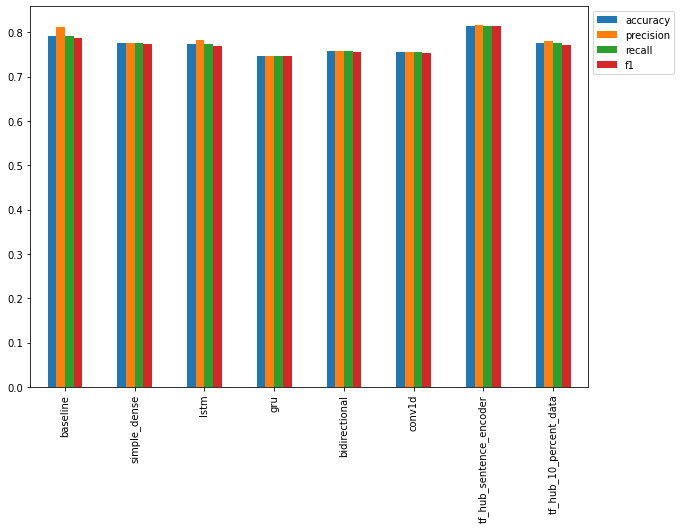

In [ ]:
all_model_results.plot(kind='bar', figsize=(10,7)).legend(bbox_to_anchor=(1.,1.))#bbox_to_anchor plots legend outside of plot

In [ ]:
# !tensorboard dev upload --logdir ./model_logs/ \
#   --name 'Learning NLP'\
#   --description 'Comaparing all the diffrent models on the Kaggle Tweets text classification dataset'\
#   --one_shot #this compand exits the uploader once uploading is finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=MzdabCA1idv9AWgZpwj6vZPlRwF30u&prompt=consent&access_type=offline

In [ ]:
model_6.save('model_6.h5')

In [ ]:
import tensorflow_hub as hub
loaded_model_6=tf.keras.models.load_model('model_6.h5',
                                          custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 21ms/step - loss: 0.4271 - accuracy: 0.8150


[0.42708083987236023, 0.8149606585502625]

In [ ]:
model_6.save('model_6_SavedModel_format')

In [ ]:
#custom_objects attribute is not required in this format
loaded_model_6_SavedModel_format=tf.keras.models.load_model('model_6_SavedModel_format')
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 11ms/step - loss: 0.4271 - accuracy: 0.8150


[0.42708083987236023, 0.8149606585502625]

Checking the most wrong predictions

In [ ]:
import pandas as pd
val_df = pd.DataFrame({"text": val_sentences,
                      "target": val_labels,
                      "pred": model_6_preds,
                      "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.161810
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.787083
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.990349
3,@camilacabello97 Internally and externally scr...,1,0.0,0.187083
4,Radiation emergency #preparedness starts with ...,1,1.0,0.648128


In [ ]:
most_wrong=val_df[val_df['target']!=val_df['pred']].sort_values('pred_prob', ascending=False)
most_wrong.head()

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.930363
759,FedEx will no longer transport bioterror patho...,0,1.0,0.889295
628,@noah_anyname That's where the concentration c...,0,1.0,0.885231
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.847435
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.846881


In [ ]:
most_wrong.tail()

,text,target,pred,pred_prob
233,I get to smoke my shit in peace,1,0.0,0.050972
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.041271
38,Why are you deluged with low self-image? Take ...,1,0.0,0.040832
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.036974
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.036585


In [ ]:
#False Positive
for row in most_wrong.head().itertuples():
  _, text, target, pred, pred_prob =row
  print(f"\nTarget: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-------------------\n")


Target: 0, Pred: 1, Prob: 0.9303627014160156
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

-------------------


Target: 0, Pred: 1, Prob: 0.8892948627471924
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

-------------------


Target: 0, Pred: 1, Prob: 0.8852306008338928
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

-------------------


Target: 0, Pred: 1, Prob: 0.8474354147911072
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

-------------------


Target: 0, Pred: 1, Prob: 0.8468806147575378
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

-------------------



In [ ]:
#False Negative
for row in most_wrong.tail().itertuples():
  _, text, target, pred, pred_prob =row
  print(f"\nTarget: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("-------------------\n")


Target: 1, Pred: 0, Prob: 0.05097202584147453
Text:
I get to smoke my shit in peace

-------------------


Target: 1, Pred: 0, Prob: 0.041270911693573
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

-------------------


Target: 1, Pred: 0, Prob: 0.04083215445280075
Text:
Why are you deluged with low self-image? Take the quiz: http://t.co/XsPqdOrIqj http://t.co/CQYvFR4UCy

-------------------


Target: 1, Pred: 0, Prob: 0.0369742177426815
Text:
Reddit Will Now QuarantineÛ_ http://t.co/pkUAMXw6pm #onlinecommunities #reddit #amageddon #freespeech #Business http://t.co/PAWvNJ4sAP

-------------------


Target: 1, Pred: 0, Prob: 0.03658505156636238
Text:
Ron &amp; Fez - Dave's High School Crush https://t.co/aN3W16c8F6 via @YouTube

-------------------



In [ ]:
test_sentences=test_df['text'].to_list()
test_samples=random.sample(test_sentences, 5)
for test_sample in test_samples:
  pred_prob=model_6.predict([test_sample])
  pred_prob=tf.squeeze(pred_prob)
  pred=tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text: \n{test_sample}\n")
  print("------\n")

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.17771199345588684
Text: 
@Followtheblonde @reba RED THUNDER AND BLONDE LIGHTNING BACK IN ACTION??????

------

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.17005792260169983
Text: 
*Ears bleeding from the bass* https://t.co/d5RrrwHjpN

------

1/1 [==============================] - 0s 52ms/step
Pred: 0, Prob: 0.18494349718093872
Text: 
AND I'M DROWNING IN THE DÌäJÌÛ VUUUUU WE'VE SEEN IT ALL BEFOOOOOOOORE

------

1/1 [==============================] - 0s 48ms/step
Pred: 0, Prob: 0.09983943402767181
Text: 
@PumpkinMari_Bot lemme just derail this real quivk to say. HELL DAMN F

------

1/1 [==============================] - 0s 57ms/step
Pred: 1, Prob: 0.9722789525985718
Text: 
Photo: #NJTurnpike å_ NJ Turnpike Reopens Hours After Truck Fire In Linden; Driver Dead | NJ Turnpike... http://t.co/8SRT9rGaX7

------



In [ ]:
import time
def pred_timer(model, samples):
  start_time=time.perf_counter()#Get start time
  model.predict(samples)
  end_time=time.perf_counter()#Get end time
  total_time=end_time-start_time
  time_per_pred=total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
model_6_pred_time, model_6_time_per_pred=pred_timer(model=model_6,
                                                    samples=val_sentences)
model_6_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 19ms/step


(0.5572295729998586, 0.0007312724055116255)

In [ ]:
baseline_total_pred_time, baseline_time_per_pred=pred_timer(model=model_0,
                                                            samples=val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.037914800999715226, 4.9756956692539665e-05)

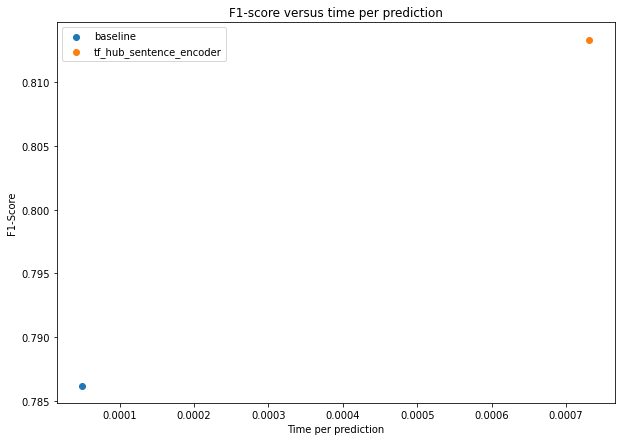

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");